In [1]:
from pathlib import Path

import os
import sys

current_path = Path(os.getcwd())
sys.path.append(str(current_path))

In [2]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [3]:
import vectorian
from vectorian.embeddings import FastText

fasttext = FastText("en")

Matching checksum for /Users/arbeit/Projects/vectorian-2021/vectorian/core/cpp/core.cpp --> not compiling


In [4]:
from vectorian.importers import NovelImporter
from vectorian.session import LabSession

im = NovelImporter(nlp)
doc = im("/Users/arbeit/A Child's Dream of a Star.txt")

session = LabSession(
    [doc],
    [fasttext])

100%|██████████| 58/58 [00:00<00:00, 130.35it/s]


In [5]:
query = nlp("large")
r = session.find(query, n=3)  # options={'pos_filter': ["NOUN"]}

FloatProgress(value=0.0, layout=Layout(width='100%'), max=1.0)

In [6]:
r.duration

0.008118867874145508

In [7]:
r

In [7]:
from vectorian.alignment import WordMoversDistance

query = nlp("large")
r = session.find(query, n=5, alignment=WordMoversDistance(relaxed=True))

FloatProgress(value=0.0, layout=Layout(width='100%'), max=1.0)

In [8]:
r

In [7]:
r[0].document.sentence(r[0].sentence)

{'book': -1,
 'chapter': -1,
 'speaker': -1,
 'paragraph': 15,
 'token_at': 421,
 'n_tokens': 53}

In [8]:
start = r[0].document.tokens["idx"][421]
end = r[0].document.tokens["idx"][421 + 53]
r[0].document.substr(start, end)

'And so the time came, all too soon! when the child looked out alone, and when there was no face on the bed; and when there was a little grave among the graves, not there before; and when the star made long rays down towards him, as he saw it through his tears.\n\n'

In [6]:
from vectorian.embeddings import Glove
glove = Glove()

session = LabSession(
    [doc],
    [fasttext, glove])

In [7]:
from vectorian.metrics import CosineMetric, LerpMetric, PNormMetric

query = nlp("play")

#r = session.find(query, n=3, metric=PNormMetric(fasttext, p=2, scale=0.1))
r = session.find(query, n=3)

#r = session.find(query, n=3, metric=LerpMetric(
#    CosineMetric(fasttext),
#    CosineMetric(glove),
#    0.8))

FloatProgress(value=0.0, layout=Layout(width='100%'), max=1.0)

In [10]:
r.duration

0.024589061737060547

In [11]:
r

In [6]:
session = LabSession(
    [doc],
    [glove])

100%|██████████| 58/58 [00:00<00:00, 114.64it/s]


In [11]:
query = nlp("short")
r = session.find(query, n=3)
r

FloatProgress(value=0.0, layout=Layout(width='100%'), max=1.0)

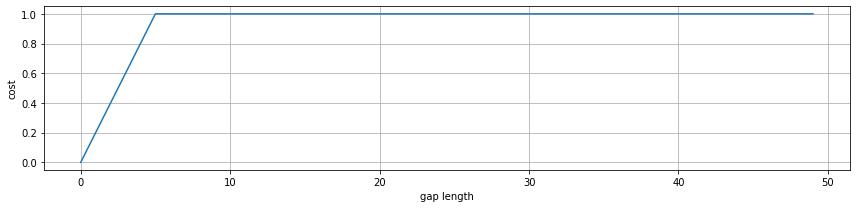

In [1]:
from vectorian.alignment import LinearGapCost, WatermanSmithBeyer

LinearGapCost(0.2)

In [3]:
#session.exponential_gap_costs(5)  # , 20)session.max_sentence_len

waterman_smith_beyer(gap=0.2, zero=0.5)

{'algorithm': 'wsb', 'gap': array([0.2], dtype=float32), 'zero': 0.5}

In [5]:
r = session.find(query, n=3, options={
    'alignment': WatermanSmithBeyer(gap=LinearGapCost(0.2), zero=0.5)
})

True

In [3]:
current_path

PosixPath('/Users/arbeit/Projects/vectorian-2021')

# Query Details Example

In [12]:
r[0].query.text

'play'

In [13]:
len(r[0].document.text)

6457

In [14]:
r[0].document.tokens

{'id': array([ 0,  1,  2, ...,  6,  6, -1], dtype=int32),
 'idx': array([   0,    2,    7, ..., 6568, 6570, 6571], dtype=int32),
 'len': array([1, 5, 4, ..., 2, 1, 0], dtype=int8),
 'pos': array([ 0,  1,  1, ...,  3,  3, -1], dtype=int8),
 'tag': array([ 0,  1,  1, ...,  3,  3, -1], dtype=int8)}

In [16]:
r[0].assignment

{'idx': array([66], dtype=int16),
 'sim': array([0.7944386], dtype=float32),
 'w': array([1.], dtype=float32)}

In [17]:
sent = r[0].document.sentence(r[0].sentence)
sent

{'book': -1,
 'chapter': -1,
 'speaker': -1,
 'paragraph': 8,
 'token_at': 110,
 'n_tokens': 101}

In [20]:
index = r[0].assignment["idx"][0] + sent["token_at"]
start = r[0].document.tokens["idx"][index]
end = start + r[0].document.tokens["len"][index]
print("match with: ", r[0].document.substr(start, end))
print("sim: ", r[0].assignment["sim"][0])

match with:  playing
sim:  0.7944386


# Interactive GUI